# Handwritten Character Recognition
Recognizing handwritten character using Convolutional Neural Network model

## Initialization
Import libraries, functions and datasets

In [1]:
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import rotate
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch

import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
cdata = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)
ddata = torchvision.datasets.EMNIST(root='emnist', split='digits', download=True)

char_images = cdata.data.view([len(cdata), 1, 28, 28]).float() # Reshapes the data into [number of samples, channels, height, width] then converts data to float
char_labels = cdata.targets - 1 # Removes the 'N/A' category
char_classes = cdata.classes[1:] # Removes the 'N/A' category

digit_images = ddata.data.view([len(ddata), 1, 28, 28]).float()
digit_labels = ddata.targets + 26
digit_classes = ddata.classes

combined_images = torch.cat((digit_images, char_images), dim=0)
combined_labels = torch.cat((digit_labels, char_labels), dim=0)
combined_classes = char_classes + digit_classes

print('ALPHABET')
print(f'Training samples: {len(cdata):,}; classes: {len(char_labels.unique()):,}; shape: {cdata.data.shape}')
print(f'Classes: {char_classes}\n')

print('DIGITS')
print(f'Training samples: {len(ddata):,}; classes: {len(digit_labels.unique())}, shape: {ddata.data.shape}')
print(f'Classes: {digit_classes}\n')

print('ALPHABET AND DIGITS')
print(f'Training samples: {len(combined_images):,}; classes: {len(combined_labels.unique()):,}; shape: {combined_images.data.shape}')
print(f'Classes: {combined_classes}')

cuda
ALPHABET
Training samples: 124,800; classes: 26; shape: torch.Size([124800, 28, 28])
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

DIGITS
Training samples: 240,000; classes: 10, shape: torch.Size([240000, 28, 28])
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

ALPHABET AND DIGITS
Training samples: 364,800; classes: 36; shape: torch.Size([364800, 1, 28, 28])
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [2]:
combined_labels.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [90]:
char_labels.shape

torch.Size([124800])

In [89]:
digit_labels.shape

torch.Size([240000])

In [88]:
torch.cat((char_images, digit_images), 0).shape

torch.Size([364800, 1, 28, 28])

In [101]:
char_labels

tensor([22,  6, 15,  ..., 12, 14, 18])

In [100]:
digit_labels

tensor([8, 9, 6,  ..., 1, 1, 0])

In [99]:
torch.Tensor([1, 2, 3, 4]) + 25

tensor([26., 27., 28., 29.])

In [94]:
torch.cat((char_labels, digit_labels), 0).unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [83]:
len(combined_classes)

36

In [84]:
len(combined_labels.unique())

26

### Visualizations
Functions for visualizing distributions, model performance and classification reports

In [14]:
def plot_sample_image(img_idx=None, is_char=True):
    if is_char:
        index = np.random.randint(0, len(cdata))
    else:
        index = np.random.randint(0, len(ddata))

    if img_idx != None:
        index = img_idx
    
    if is_char:
        sample_image = cdata.data[index]  
        sample_label = char_labels[index]
    else:
        sample_image = ddata.data[index]  
        sample_label = digit_labels[index]
    
    plt.imshow(sample_image.numpy().T, cmap='gray')
    if is_char:
        plt.title(f'Class: {char_classes[sample_label]}')
    else:
        plt.title(f'Class: {digit_classes[sample_label - 26]}')
    plt.axis('off')
    plt.show()

def plot_sample_images(num_images=10, is_char=True):
    if is_char:
        indices = np.random.choice(len(cdata), num_images, replace=False)
    else:
        indices = np.random.choice(len(ddata), num_images, replace=False)

    _, axes = plt.subplots(1, num_images, figsize=(16, 16))
    for ax, idx in zip(axes.flatten(), indices):
        if is_char:
            image = cdata.data[idx]
            label = char_labels[idx]
        else:
            image = ddata.data[idx]
            label = digit_labels[idx]
        
        ax.imshow(image.numpy().T, cmap='gray')
        if is_char:
            ax.set_title(f'{char_classes[label]}')
        else:
            ax.set_title(f'{digit_classes[label - 26]}')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def plot_class_distribution(is_char=True):
    histogram = {}

    if is_char:
        for i in char_labels:
            c = char_classes[i]
            if c not in histogram:
                histogram[c] = 1
            else:
                histogram[c] += 1
    else:
        for i in digit_labels:
            c = digit_classes[i - 26]
            if c not in histogram:
                histogram[c] = 1
            else:
                histogram[c] += 1

    plt.bar(list(histogram.keys()), list(histogram.values()))
    plt.show()

def plot_model_performance(train_loss, test_loss, train_error, test_error):
    _, ax = plt.subplots(1, 2, figsize=(16, 5))

    print(train_loss, test_loss)

    ax[0].plot(train_loss, 's-', label='Train')
    ax[0].plot(test_loss, 'o-', label='Test')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].set_title(f'Final train loss: {train_loss[-1]:.2f}, test loss: {test_loss[-1]:.2f}')

    ax[1].plot(train_error, 's-', label='Train')
    ax[1].plot(test_error, 'o-', label='Test')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Error rates (%)')
    ax[1].set_title(f'Final test error rate: {test_error[-1]:.2f}%')
    ax[1].legend()

    plt.show()

def conf_matrix_and_report(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(all_labels, all_preds, target_names=classes))

In [4]:
print(digit_labels[300] - 26, digit_classes[digit_labels[300] - 26])

tensor(8) 8


## Basic EDA

### Alphabet

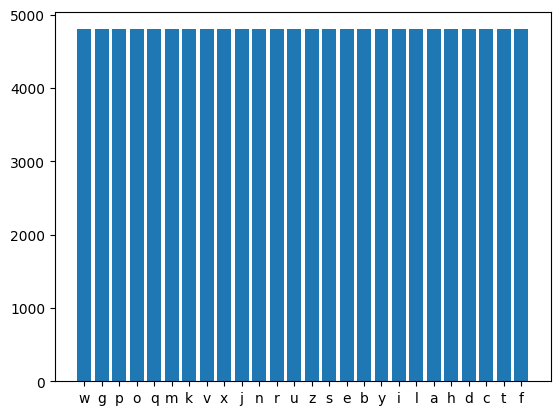

In [5]:
plot_class_distribution()

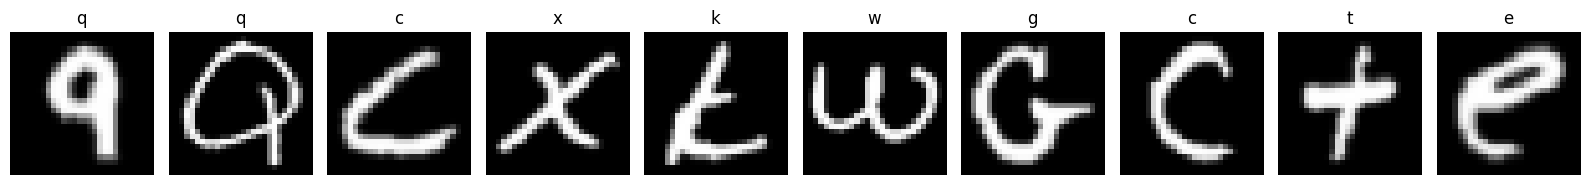

In [6]:
plot_sample_images(num_images=10)

Label: k
Matrix:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   7  27   7   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   7  90 187  88  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  32 202 249 157  68   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  50 222 250 129  39   0   0   0   0   0   0   0   0   0   4   4   4   0   0   0   0]
 [  0   0   0   0   0   0   2  81 233 250 127  37   0   0   0   0   0   0   0   0   7  32  37  32   7   0   0   0]
 [  0   0   0   0   0   0   2  81 233 250 127  37   0   0   0   0   0   0   3  22  95 202 215 201  75   2   0   0]
 [  0   0   0   0   0   0   0  52 223 245 114  32   0   0   0 

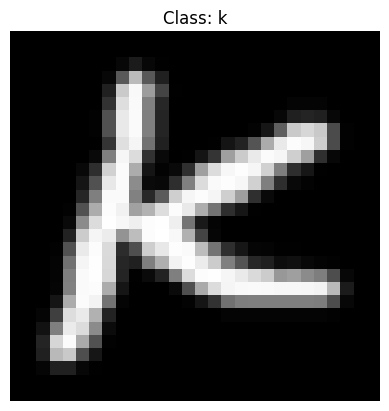

In [7]:
np.set_printoptions(linewidth=150)
print('Label:', char_classes[char_labels[370]])
print('Matrix:\n', cdata.data[370].numpy().T)
plot_sample_image(img_idx=370)

### Digits

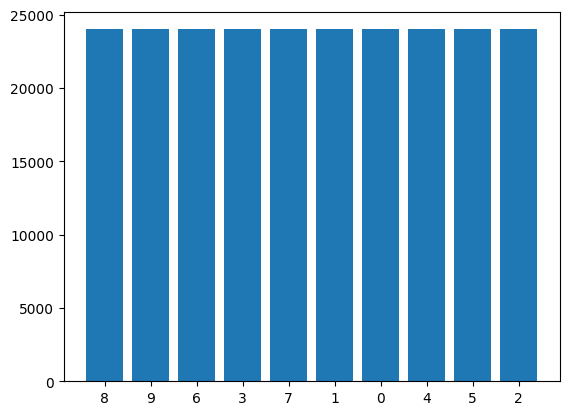

In [10]:
plot_class_distribution(is_char=False)

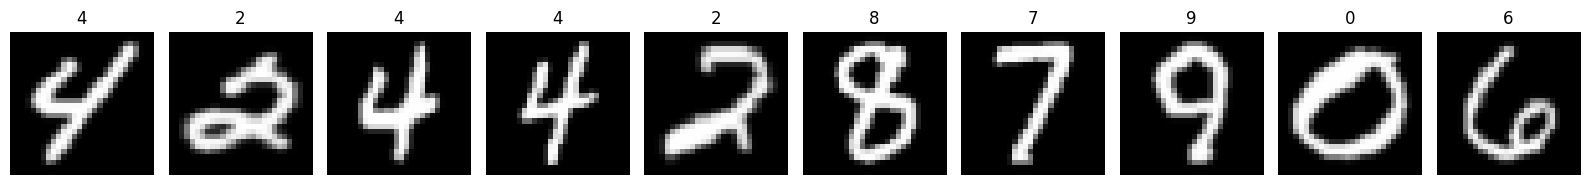

In [11]:
plot_sample_images(num_images=10, is_char=False)

Label: 3
Matrix:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   4   4   4   4   4   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2   9  82 125 127 127 127 127 114  39  32   7   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  20  81 139 232 249 250 250 250 250 245 217 202  90   9   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3 109 229 250 254 254 254 254 254 254 254 254 253 219  91   8   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4 114 245 254 250 249 233 217 217 217 217 245 252 253 218  77   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0  22 154 200  52  37  21   5   4   4   5  41 159 251 250 127   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1  20  32   1   0   0   0   0   0   4  48 209 254 250 127   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

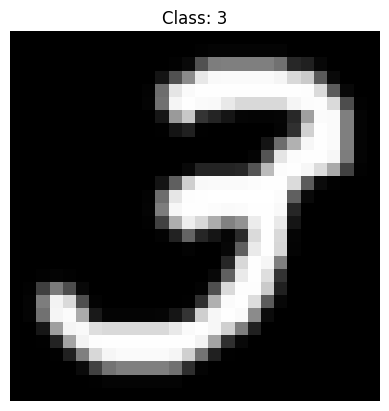

In [15]:
np.set_printoptions(linewidth=150)
print('Label:', digit_classes[digit_labels[370] - 26])
print('Matrix:\n', ddata.data[370].numpy().T)
plot_sample_image(img_idx=370, is_char=False)

## CNN
The model takes an input of 28×28 grayscale image and outputs a prediction of the 26 alphabetic character classes.
<br>
<br>
![alt text](<CNN Model.png>)
<br>
<br>
- First Convolutional Layer:
    - Input: (single-channel grayscale image)
    - Kernel size: 3×3, padding = 1, stride = 1
    - Output size (before pooling): 28×28×6
        <br>
        <br>
        - First convolution size $\large\ =\ \frac{Input\ size\ +\ 2\ \times\ Padding\ -\ Kernel\ size}{Stride}\ +\ 1\ =\ \frac{28\ +\ 2\ \times\ 1\ -\ 3}{1}\ +\ 1\ =\ 28$
        <br>
        <br>
        - **Resulting feature map: 28×28×6**
    - After max pooling (2×2, stride = 2):
        <br>
        <br>
        - First max pooling size $\large\ =\ \frac{Input\ size\ -\ Pool\ size}{Stride}\ +\ 1\ =\ \frac{28\ -\ 2}{2}\ +\ 1\ =\ 14$
        <br>
        <br>
        - **Resulting feature map: 14×14×6**
- Second Convolutional Layer:
    - Input: 14×14×6
    - Kernel size: 3×3, padding = 1, stride = 1
    - Output size (before pooling): 14×14×6
        <br>
        <br>
        - Second convolution size $\large\ =\ \frac{14\ +\ 2\ \times\ 1\ -\ 3}{1}\ +\ 1\ =\ 14$
        <br>
        <br>
        - **Resulting feature map: 14×14×6**
    - After max pooling (2×2, stride = 2):
        <br>
        <br>
        - Second max pooling size $\large\ =\ \frac{14\ -\ 2}{2}\ +\ 1\ =\ 7$
        <br>
        <br>
        - **Resulting feature map: 7×7×6**
- Flattening for Fully Connected Layers:
    - 7×7×6 = 294
    <br>
    <br>
    - **294 pixels becomes the input to the first fully connected layer.**

In [16]:
def cnn_model(printtoggle=False, output_layers=26):
    class emnistnet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            self.print = printtoggle

            # First Convolution Layer: 1 input channel, 6 output channels, and a 3x3 kernel with padding of 1
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(6)

            # Second Convolution Layer: 6 input channels, 6 output channels, and a 3x3 kernel with padding of 1
            self.conv2 = nn.Conv2d(6, 6, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)

            # Neural Network Input Layer: 294 input features connected to hidden layer
            self.fc1 = nn.Linear(7 * 7 * 6, 50)
            # Neural Network Hidden Layer: 50 input neurons connected to 26 output feature results
            self.fc2 = nn.Linear(50, output_layers)

        def forward(self, x):
            if self.print:
                print(f'Input: {list(x.shape)}')

            # First Block: Convolution -> Max Pooling -> Batch Normalization -> Relu Activation
            x = F.max_pool2d(self.conv1(x), 2) # Kernel size = 2, Stride = 2
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:
                print(f'First CPR block: {list(x.shape)}')

            # Second Block: Convolution -> Max Pooling -> Batch Normalization -> Relu Activation
            x = F.max_pool2d(self.conv2(x), 2) # Kernel size = 2, Stride = 2
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:
                print(f'Second CPR block: {list(x.shape)}')

            # Reshapes the (7x7) 6 feature map to 294 input features for Neural Network
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            if self.print:
                print(f'Vectorized: {list(x.shape)}')

            # Neural Network Input Layer: 294 input features connected to hidden layer with 50 input neurons
            x = F.leaky_relu(self.fc1(x))
            # Neural Network Hidden Layer: 50 input neurons connected to 26 output feature results
            x = self.fc2(x)
            if self.print:
                print(f'Final output: {list(x.shape)}')

            return x

    net = emnistnet(printtoggle)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer

def train_model(train_char_loader: DataLoader, test_char_loader: DataLoader, num_epochs=10, output_layers=26):
    net, lossfun, optimizer = cnn_model(output_layers=output_layers)
    net.to(device) # Send model to GPU

    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)

    train_error = torch.zeros(num_epochs)
    test_error = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        print(f"EPOCH: {epoch}")
        net.train()
        batch_loss = []
        batch_error = []

        # Forward and backward propagate for all batches
        for x, y in train_char_loader:
            # Push data to GPU
            x = x.to(device)
            y = y.to(device)

            # Forward progagate and calculate loss
            y_hat = net(x)
            loss = lossfun(y_hat, y)

            # Backward propagate and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Append loss and error from this batch
            batch_loss.append(loss.item())
            batch_error.append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

        # Get average losses and error rates across the batches from training data
        train_loss[epoch] = np.mean(batch_loss)
        train_error[epoch] = 100 * np.mean(batch_error)
        print(f"TRAIN LOSS: {train_loss[epoch]}, TRAIN ERROR: {train_error[epoch]}")

        # Forward propagate on testing data to calculate test loss and test error
        net.eval()
        x_test, y_test = next(iter(test_char_loader))
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            y_hat_test = net(x_test)
            lossfun_test = lossfun(y_hat_test, y_test)

        # Get average losses and error rates from testing data
        test_loss[epoch] = lossfun_test.item()
        test_error[epoch] = 100 * torch.mean((torch.argmax(y_hat_test, axis=1)!= y_test).float()).item()
        print(f"TEST LOSS: {test_loss[epoch]}, TEST ERROR: {test_error[epoch]}")

    return train_loss, test_loss, train_error, test_error, net

## Entrypoint

### Dataset Preparation

In [18]:
def data_prep(images, labels):
    # Normalize images
    images /= torch.max(images)
    # Split dataset into training and testing data 
    train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)
    # Convert dataset into PyTorch dataset
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)
    # Load dataset into data loader objects
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], shuffle=True, drop_last=True)

    return train_loader, test_loader

def oversample_test_data(test_loader):
    # Combine test data into a single batch
    all_data, all_labels = [], []
    for x, y in test_loader:
        all_data.append(x)
        all_labels.append(y)
    
    # Concatenate all batches
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Perform oversampling
    oversampler = RandomOverSampler()
    data_flat = all_data.view(all_data.shape[0], -1).numpy()
    labels_flat = all_labels.numpy()
    data_oversampled, labels_oversampled = oversampler.fit_resample(data_flat, labels_flat)

    # Reshape oversampled data
    data_oversampled = torch.tensor(data_oversampled).view(-1, 1, 28, 28).float()
    labels_oversampled = torch.tensor(labels_oversampled)

    # Return a new dataloader with oversampled data
    oversampled_dataset = TensorDataset(data_oversampled, labels_oversampled)
    return DataLoader(oversampled_dataset, batch_size=test_loader.batch_size, shuffle=True)

def undersample_test_data(test_loader):
    # Combine test data into a single batch
    all_data, all_labels = [], []
    for x, y in test_loader:
        all_data.append(x)
        all_labels.append(y)
    
    # Concatenate all batches
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Perform undersampling
    undersampler = RandomUnderSampler()
    data_flat = all_data.view(all_data.shape[0], -1).numpy()
    labels_flat = all_labels.numpy()
    data_undersampled, labels_undersampled = undersampler.fit_resample(data_flat, labels_flat)

    # Reshape undersampled data
    data_undersampled = torch.tensor(data_undersampled).view(-1, 1, 28, 28).float()
    labels_undersampled = torch.tensor(labels_undersampled)

    # Return a new dataloader with undersampled data
    undersampled_dataset = TensorDataset(data_undersampled, labels_undersampled)
    return DataLoader(undersampled_dataset, batch_size=test_loader.batch_size, shuffle=True)

### Model Training

#### Step by Step

In [8]:
# DATA PREPARATION
# Normalize images
char_images /= torch.max(char_images)
print('Shape:\n', char_images.shape)

Shape:
 torch.Size([124800, 1, 28, 28])


In [9]:
# Splits the dataset into training dataset (90%) and testing dataset (10%)
train_char_data, test_char_data, train_char_labels, test_char_labels = train_test_split(char_images, char_labels, test_size=.1)
print('Training dataset shape and label:\n', train_char_data.shape, train_char_labels.shape)
print('Testing dataset shape and label:\n', test_char_data.shape, test_char_labels.shape)

Training dataset shape and label:
 torch.Size([112320, 1, 28, 28]) torch.Size([112320])
Testing dataset shape and label:
 torch.Size([12480, 1, 28, 28]) torch.Size([12480])


In [10]:
# Converts the training and testing dataset into Tensor dataset
train_char_data = TensorDataset(train_char_data, train_char_labels)
test_char_data = TensorDataset(test_char_data, test_char_labels)
print('Training Tensor dataset shape:\n', train_char_data.tensors[0].shape)
print('Testing Tensor dataset shape:\n', test_char_data.tensors[0].shape)

Training Tensor dataset shape:
 torch.Size([112320, 1, 28, 28])
Testing Tensor dataset shape:
 torch.Size([12480, 1, 28, 28])


In [14]:
# Loads the Tensor training and testing dataset into a data loader to shuffle and arrange into batches
train_char_loader = DataLoader(train_char_data, batch_size=32, shuffle=True, drop_last=True) # 32 Samples for each batch
test_char_loader = DataLoader(test_char_data, batch_size=test_char_data.tensors[0].shape[0], shuffle=True, drop_last=True) # All samples in one batch

In [15]:
# MODEL TRAINING
# Initialize the model, loss function, and optimizer
num_epochs = 10
net, lossfun, optimizer = cnn_model(output_layers=26)
net.to(device)

train_loss = torch.zeros(num_epochs)
test_loss = torch.zeros(num_epochs)

train_error = torch.zeros(num_epochs)
test_error = torch.zeros(num_epochs)

In [16]:
# Switch the model into training mode
net.train()

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)

In [ ]:
# Load one batch (32 samples) into x (Data) and y (Actual labels)
x, y = next(iter(train_char_loader))

Shape:
 torch.Size([32, 1, 28, 28])
y:
 tensor([ 7, 19, 16, 13,  5, 25, 15, 15, 21, 23, 15,  3,  5, 12, 13, 20, 20,  3, 25, 22, 11, 18,  2, 20, 23, 12,  5,  8, 24, 17, 11, 24])


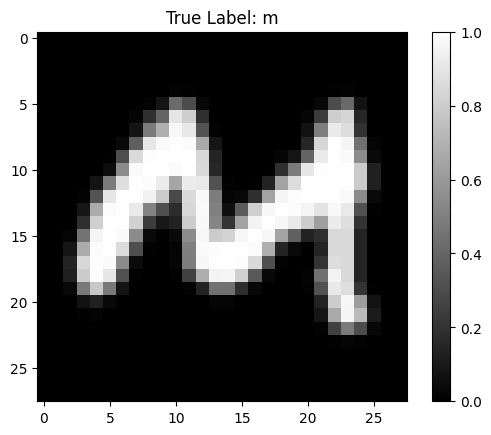

In [106]:
# Single training sample from a batch
# torch.set_printoptions(linewidth=400, sci_mode=False)
print('Shape:\n', x.shape)
print('y:\n', y)

def show_sample_from_batch():
    char_map = {i: chr(97 + i) for i in range(26)}
    i = 25

    plt.imshow(x[i][0].numpy().T, cmap='gray')  # Use a grayscale colormap
    plt.colorbar()  # Optional: adds a color scale to the side
    plt.title(f'True Label: {char_map[int(y[i])]}')
    plt.show()

show_sample_from_batch()

##### Visualization of Convolution
Visualization of convolutional layers

In [111]:
torch.from_numpy(x[25][0].numpy().T).to(device).unsqueeze(0)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [94]:
net

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)

In [96]:
net_layers = list(net.children())
net_layers

[Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=294, out_features=50, bias=True),
 Linear(in_features=50, out_features=26, bias=True)]

In [ ]:
net_layers[0](torch.from_numpy(x[25][0].numpy().T).to(device).unsqueeze(0)).shape

torch.Size([6, 28, 28])

In [171]:
def forward_prop_single_batch(i=25):
    x_out = x.to(device)
    layers = {}

    # Step 1: Apply the first convolution layer
    conv1_output = net.conv1(x_out)  # Shape: [6, 28, 28]
    print('conv1_output shape:', conv1_output.shape)
    layers['conv1_output'] = conv1_output[i]

    # Step 2: Apply max pooling
    conv1_pool = F.max_pool2d(conv1_output, 2)  # Shape: [6, 14, 14]
    print('conv1_pool shape:', conv1_pool.shape)
    layers['conv1_pool'] = conv1_pool[i]

    # Step 3: Apply batch normalization
    conv1_bn = net.bnorm1(conv1_pool)  # Shape: [6, 14, 14]
    print('conv1_bnorm shape:', conv1_bn.shape)

    # Step 4: Apply activation function
    conv1_activated = F.leaky_relu(conv1_bn)  # Shape: [6, 14, 14]
    print('conv1_activated shape:', conv1_activated.shape)

    # Step 5: Apply the second convolution layer
    conv2_output = net.conv2(conv1_activated)  # Shape: [6, 14, 14]
    print('conv2_output shape:', conv2_output.shape)
    layers['conv2_output'] = conv2_output[i]

    # Step 6: Apply max pooling
    conv2_pool = F.max_pool2d(conv2_output, 2)  # Shape: [6, 7, 7]
    print('conv2_pool shape:', conv2_pool.shape)
    layers['conv2_pool'] = conv2_pool[i]

    # Step 7: Apply batch normalization
    conv2_bn = net.bnorm2(conv2_pool)  # Shape: [6, 7, 7]
    print('conv2_bn shape:', conv2_bn.shape)

    # Step 8: Apply activation function
    conv2_activated = F.leaky_relu(conv2_bn)  # Shape: [6, 7, 7]
    print('conv2_activated shape:', conv2_activated.shape)

    return layers

In [172]:
conv_layers = forward_prop_single_batch()

conv1_output shape: torch.Size([32, 6, 28, 28])
conv1_pool shape: torch.Size([32, 6, 14, 14])
conv1_bnorm shape: torch.Size([32, 6, 14, 14])
conv1_activated shape: torch.Size([32, 6, 14, 14])
conv2_output shape: torch.Size([32, 6, 14, 14])
conv2_pool shape: torch.Size([32, 6, 7, 7])
conv2_bn shape: torch.Size([32, 6, 7, 7])
conv2_activated shape: torch.Size([32, 6, 7, 7])


In [173]:
conv_layers.keys()

dict_keys(['conv1_output', 'conv1_pool', 'conv2_output', 'conv2_pool'])

In [174]:
conv_layers['conv1_pool'].unsqueeze(0).detach().cpu().shape

torch.Size([1, 6, 14, 14])

FIRST CONVOLUTIONAL LAYER
Shape: torch.Size([6, 28, 28])


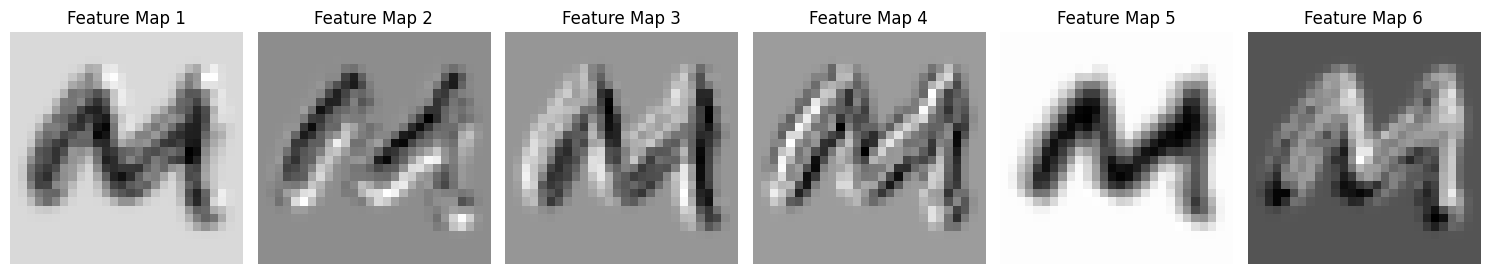

FIRST MAX POOLING LAYER
Shape: torch.Size([6, 14, 14])


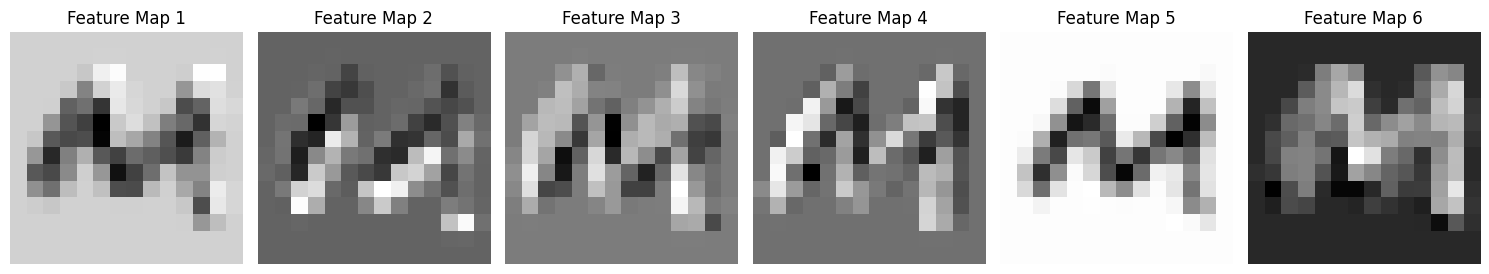

SECOND CONVOLUTIONAL LAYER
Shape: torch.Size([6, 14, 14])


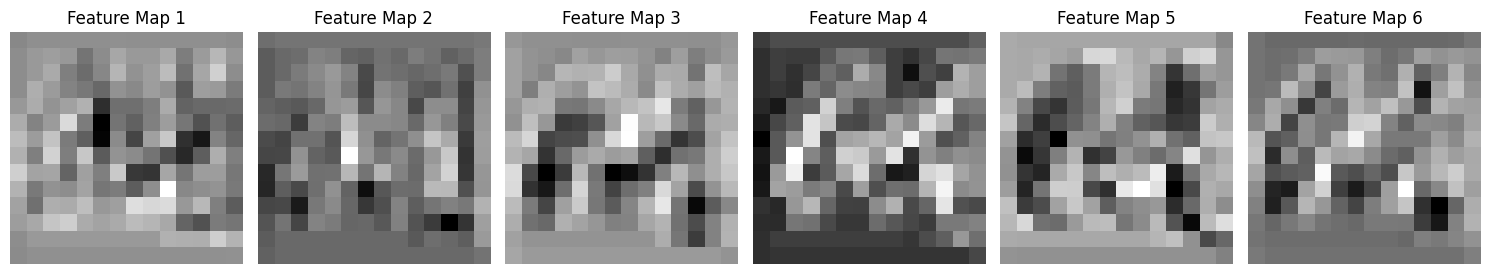

SECOND MAX POOLING LAYER
Shape: torch.Size([6, 7, 7])


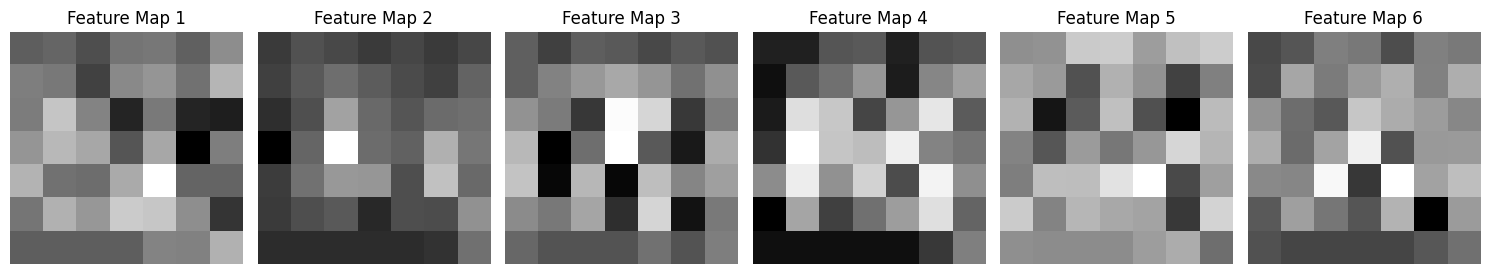

In [175]:
def visualize_all_layers():
    print('FIRST CONVOLUTIONAL LAYER')
    print('Shape:', conv_layers['conv1_output'].shape)
    conv1 = conv_layers['conv1_output'].unsqueeze(0) # Shape: [1, 6, 28, 28]
    conv1 = conv1.detach().cpu()

    # Visualize each channel (6 feature maps) from first convolutional layer
    num_channels_conv1 = conv1.shape[1]
    _, axes_conv1 = plt.subplots(1, num_channels_conv1, figsize=(15, 15))
    for i, ax in enumerate(axes_conv1):
        ax.imshow(conv1[0][i].numpy().T, cmap='gray') # Convert tensor to numpy array
        ax.set_title(f'Feature Map {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    print('FIRST MAX POOLING LAYER')
    print('Shape:', conv_layers['conv1_pool'].shape)
    conv1_pool = conv_layers['conv1_pool'].unsqueeze(0) # Shape: [1, 6, 14, 14]
    conv1_pool = conv1_pool.detach().cpu()

    # Visualize each channel (6 feature maps) from first max pooling layer
    num_channels_conv1_pool = conv1_pool.shape[1]
    _, axes_conv1_pool = plt.subplots(1, num_channels_conv1_pool, figsize=(15, 15))
    for i, ax in enumerate(axes_conv1_pool):
        ax.imshow(conv1_pool[0][i].numpy().T, cmap='gray') # Convert tensor to numpy array
        ax.set_title(f'Feature Map {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    print('SECOND CONVOLUTIONAL LAYER')
    print('Shape:', conv_layers['conv2_output'].shape)
    conv2 = conv_layers['conv2_output'].unsqueeze(0) # Shape: [1, 6, 14, 14]
    conv2 = conv2.detach().cpu()

    # Visualize each channel (6 feature maps) from second convolutional layer
    num_channels_conv2 = conv2.shape[1]
    _, axes_conv2 = plt.subplots(1, num_channels_conv2, figsize=(15, 15))
    for i, ax in enumerate(axes_conv2):
        ax.imshow(conv2[0][i].numpy().T, cmap='gray') # Convert tensor to numpy array
        ax.set_title(f'Feature Map {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    print('SECOND MAX POOLING LAYER')
    print('Shape:', conv_layers['conv2_pool'].shape)
    conv2_pool = conv_layers['conv2_pool'].unsqueeze(0) # Shape: [1, 6, 14, 14]
    conv2_pool = conv2_pool.detach().cpu()

    # Visualize each channel (6 feature maps) from second convolutional layer
    num_channels_conv2_pool = conv2_pool.shape[1]
    _, axes_conv2_pool = plt.subplots(1, num_channels_conv2_pool, figsize=(15, 15))
    for i, ax in enumerate(axes_conv2_pool):
        ax.imshow(conv2_pool[0][i].numpy().T, cmap='gray') # Convert tensor to numpy array
        ax.set_title(f'Feature Map {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_all_layers()

##### Feed Forward Propagation

In [24]:
# Push batch into the GPU
x = x.to(device)
y = y.to(device)
# Forward propagation
y_hat = net(x)
# Obtain loss value from the predicted results y_hat and actual labels y
loss = lossfun(y_hat, y)
print('y_hat shape:\n', y_hat.shape, '\n')
print('Loss:\n', loss.item(), '\n')
print('Prediction from one sample:\n', y_hat[0], '\n')

y_hat shape:
 torch.Size([32, 26]) 

Loss:
 3.272477865219116 

Prediction from one sample:
 tensor([ 0.3416,  0.1855, -0.1470,  0.3454,  0.0635,  0.2276, -0.1977, -0.0777,
         0.1609,  0.2164, -0.2864, -0.2873, -0.0328,  0.0323, -0.0086, -0.0033,
        -0.0716,  0.1610, -0.0732,  0.0406, -0.0662,  0.0901,  0.0023,  0.0573,
        -0.0208, -0.2142], device='cuda:0', grad_fn=<SelectBackward0>) 



In [ ]:
# Calculate the error rate from a single batch
# torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item()

# Step 1: Selects the index of the maximum value along the specified axis (axis=1, i.e., across classes)
# Purpose: Find the predicted class for each sample in the batch.

# EXAMPLE
# y_hat = [[0.1, 0.8, 0.1],
#          [0.4, 0.4, 0.2],
#          [0.3, 0.1, 0.6],
#          [0.7, 0.2, 0.1]]

# torch.argmax(y_hat, axis=1), Outputs: [1, 0, 2, 0]

print('torch.argmax(y_hat, axis=1) ->\n', torch.argmax(y_hat, axis=1), '\n')

# Step 2: Compare the predicted class (torch.argmax(y_hat, axis=1)) with the actual class (y)
# Purpose: A boolean tensor indicating where predictions are incorrect.

# EXAMPLE
# y = [1, 2, 2, 0] where y is the actual labels for the batch
# torch.argmax(y_hat, axis=1) != y, Outputs: [False, True, False, False]

print('y ->\n', y)
print('torch.argmax(y_hat, axis=1) != y ->\n', torch.argmax(y_hat, axis=1) != y, '\n')

# Step 3: Converts the boolean tensor into a float tensor (containing 1.0 for True and 0.0 for False)

# EXAMPLE
# (torch.argmax(y_hat, axis=1) != y).float(), Outputs: [0.0, 1.0, 0.0, 0.0]

# Step 4: Calculate the mean of the tensor, which corresponds to the fraction of incorrect predictions (error rate) for the batch.

# EXAMPLE
# torch.mean((torch.argmax(y_hat, axis=1) != y).float()), Outputs: 0.25
# This indicates that 25% of the predictions in this batch were incorrect.

print('torch.mean((torch.argmax(y_hat, axis=1) != y).float()) ->\n', torch.mean((torch.argmax(y_hat, axis=1) != y).float()), '\n')

# Step 5: Converts the single-element PyTorch tensor (e.g., tensor(0.25)) into a standard Python float.

print('torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item() ->\n', torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item(), '\n')

torch.argmax(y_hat, axis=1) ->
 tensor([ 3,  9,  9,  8,  0,  9,  3,  9,  8,  9, 23,  3, 23,  8,  3,  8,  7,  8,
         5, 23,  4,  8,  9,  9,  9, 23,  0,  3,  7,  9,  8, 21],
       device='cuda:0') 

y ->
 tensor([ 2, 16, 12, 10, 20,  3, 19, 18,  8, 16, 12, 19, 12, 16, 11,  3, 11, 15,
        20,  0,  6, 13,  4, 24, 13, 24,  0, 24, 11, 15, 14,  1],
       device='cuda:0')
torch.argmax(y_hat, axis=1) != y ->
 tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True], device='cuda:0') 

torch.mean((torch.argmax(y_hat, axis=1) != y).float()) ->
 tensor(0.9375, device='cuda:0') 

torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item() ->
 0.9375 



#### Iteration

In [35]:
# Train using character and digit images
train_char_digit_loader, test_char_digit_loader = data_prep(images=combined_images, labels=combined_labels)
balanced_train_char_digit_loader = undersample_test_data(train_char_digit_loader)
balanced_test_char_digit_loader = undersample_test_data(test_char_digit_loader)

print('Training dataset:\n', train_char_digit_loader.dataset.tensors[0].shape, '\n')
print('Testing dataset:\n', test_char_digit_loader.dataset.tensors[0].shape, '\n')
print('Undersampled training dataset:\n', balanced_train_char_digit_loader.dataset.tensors[0].shape, '\n')
print('Undersampled testing dataset:\n', balanced_test_char_digit_loader.dataset.tensors[0].shape, '\n')

Training dataset:
 torch.Size([328320, 1, 28, 28]) 

Testing dataset:
 torch.Size([36480, 1, 28, 28]) 

Undersampled training dataset:
 torch.Size([153828, 1, 28, 28]) 

Undersampled testing dataset:
 torch.Size([15192, 1, 28, 28]) 



In [26]:
train_char_digit_loader.dataset.tensors[0].shape

torch.Size([328320, 1, 28, 28])

In [36]:
train_cd_loss, test_cd_loss, train_cd_error, test_cd_error, net_cd = train_model(
    train_char_loader=train_char_digit_loader, test_char_loader=test_char_digit_loader, num_epochs=10, output_layers=36)

EPOCH: 0
TRAIN LOSS: 0.4406370222568512, TRAIN ERROR: 13.29891586303711
TEST LOSS: 0.32978829741477966, TEST ERROR: 10.241228103637695
EPOCH: 1
TRAIN LOSS: 0.3112543225288391, TRAIN ERROR: 9.840399742126465
TEST LOSS: 0.3076499402523041, TEST ERROR: 9.920504570007324
EPOCH: 2
TRAIN LOSS: 0.28774961829185486, TRAIN ERROR: 9.189510345458984
TEST LOSS: 0.2837933897972107, TEST ERROR: 9.089912414550781
EPOCH: 3
TRAIN LOSS: 0.2748408317565918, TRAIN ERROR: 8.868786811828613
TEST LOSS: 0.2851688265800476, TEST ERROR: 9.163926124572754
EPOCH: 4
TRAIN LOSS: 0.26620665192604065, TRAIN ERROR: 8.606542587280273
TEST LOSS: 0.27861276268959045, TEST ERROR: 8.983004570007324
EPOCH: 5
TRAIN LOSS: 0.2592141330242157, TRAIN ERROR: 8.381152153015137
TEST LOSS: 0.27281254529953003, TEST ERROR: 8.815790176391602
EPOCH: 6
TRAIN LOSS: 0.25433549284935, TRAIN ERROR: 8.280336380004883
TEST LOSS: 0.2715701460838318, TEST ERROR: 8.728070259094238
EPOCH: 7
TRAIN LOSS: 0.25035232305526733, TRAIN ERROR: 8.11464405

In [ ]:
# Train using character images
train_char_loader, test_char_loader = data_prep(images=char_images, labels=char_labels)
train_loss, test_loss, train_error, test_error, net = train_model(train_char_loader=train_char_loader, test_char_loader=test_char_loader, num_epochs=10, output_layers=26)

EPOCH: 0
TRAIN LOSS: 0.5705711841583252, TRAIN ERROR: 17.272079467773438
TEST LOSS: 0.35566607117652893, TEST ERROR: 11.378205299377441
EPOCH: 1
TRAIN LOSS: 0.318326860666275, TRAIN ERROR: 10.275106430053711
TEST LOSS: 0.29687371850013733, TEST ERROR: 9.342948913574219
EPOCH: 2
TRAIN LOSS: 0.2762957513332367, TRAIN ERROR: 9.093661308288574
TEST LOSS: 0.2710835635662079, TEST ERROR: 8.589743614196777
EPOCH: 3
TRAIN LOSS: 0.25472554564476013, TRAIN ERROR: 8.495369911193848
TEST LOSS: 0.27419960498809814, TEST ERROR: 8.621795654296875
EPOCH: 4
TRAIN LOSS: 0.23875592648983002, TRAIN ERROR: 7.9273505210876465
TEST LOSS: 0.2631647288799286, TEST ERROR: 8.445512771606445
EPOCH: 5
TRAIN LOSS: 0.22812001407146454, TRAIN ERROR: 7.638888835906982
TEST LOSS: 0.25907665491104126, TEST ERROR: 8.253205299377441
EPOCH: 6
TRAIN LOSS: 0.22030597925186157, TRAIN ERROR: 7.4910969734191895
TEST LOSS: 0.24543669819831848, TEST ERROR: 7.724359035491943
EPOCH: 7
TRAIN LOSS: 0.21247640252113342, TRAIN ERROR: 7

### Evaluation

#### Loss and Error Rate

tensor([0.5706, 0.3183, 0.2763, 0.2547, 0.2388, 0.2281, 0.2203, 0.2125, 0.2064,
        0.2014]) tensor([0.3557, 0.2969, 0.2711, 0.2742, 0.2632, 0.2591, 0.2454, 0.2458, 0.2382,
        0.2565])


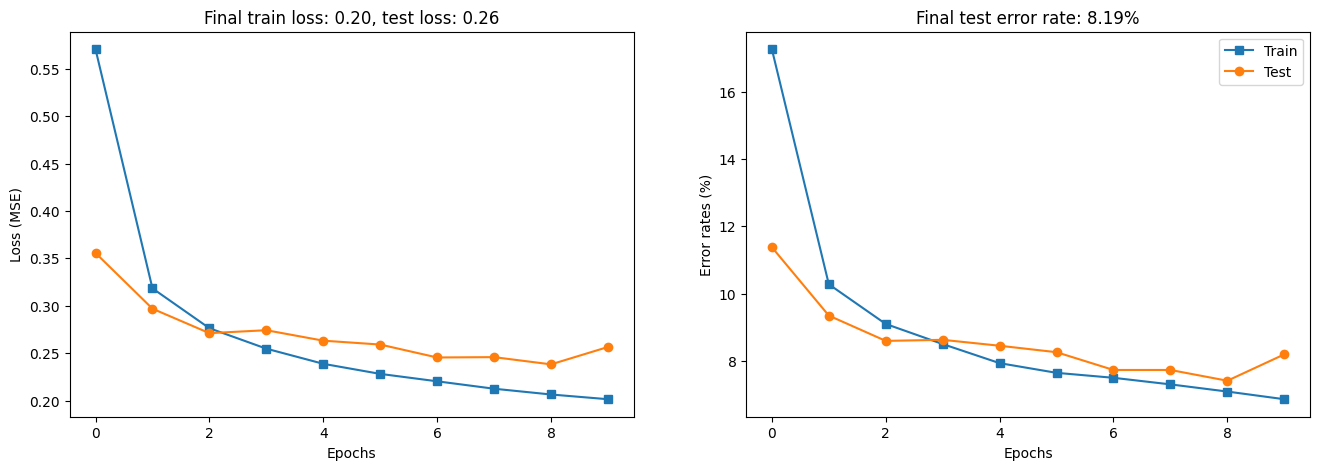

In [ ]:
# Alphabet character only
plot_model_performance(train_loss, test_loss, train_error, test_error)

tensor([0.4406, 0.3113, 0.2877, 0.2748, 0.2662, 0.2592, 0.2543, 0.2504, 0.2469,
        0.2436]) tensor([0.3298, 0.3076, 0.2838, 0.2852, 0.2786, 0.2728, 0.2716, 0.2778, 0.2683,
        0.2635])


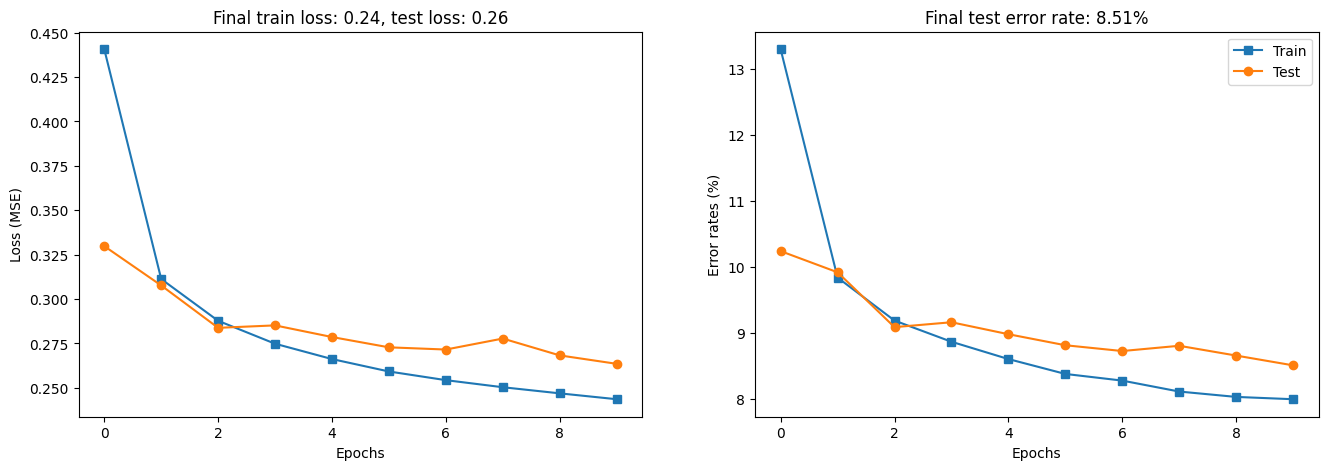

In [ ]:
# Alphabet character and digits
plot_model_performance(train_cd_loss, test_cd_loss, train_cd_error, test_cd_error)

#### Confusion Matrix and Report
Confusion matrix and classification report for test dataset

In [65]:
def evaluate_model(net, test_loader, classes):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            yHat = net(x)
            preds = torch.argmax(yHat, axis=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    conf_matrix_and_report(all_labels, all_preds, classes)

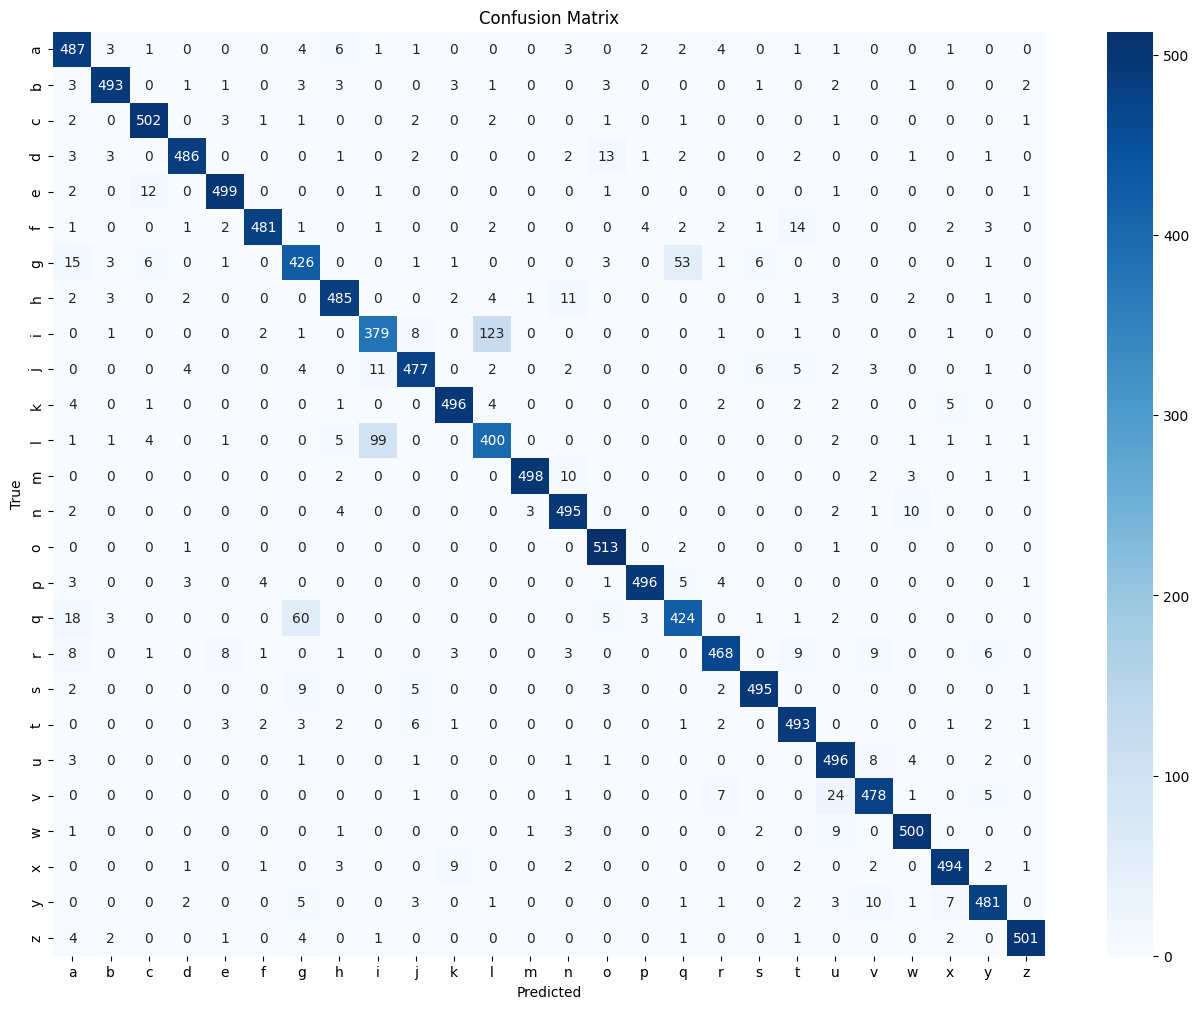

              precision    recall  f1-score   support

           a       0.87      0.94      0.90       517
           b       0.96      0.95      0.96       517
           c       0.95      0.97      0.96       517
           d       0.97      0.94      0.95       517
           e       0.96      0.97      0.96       517
           f       0.98      0.93      0.95       517
           g       0.82      0.82      0.82       517
           h       0.94      0.94      0.94       517
           i       0.77      0.73      0.75       517
           j       0.94      0.92      0.93       517
           k       0.96      0.96      0.96       517
           l       0.74      0.77      0.76       517
           m       0.99      0.96      0.98       517
           n       0.93      0.96      0.94       517
           o       0.94      0.99      0.97       517
           p       0.98      0.96      0.97       517
           q       0.86      0.82      0.84       517
           r       0.95    

In [13]:
balanced_test_loader = oversample_test_data(test_char_loader)
evaluate_model(net, balanced_test_loader, char_classes)

In [59]:
balanced_test_char_digit_loader = undersample_test_data(test_char_digit_loader)

In [62]:
balanced_test_char_digit_loader.dataset.tensors[0].shape

torch.Size([11284, 1, 28, 28])

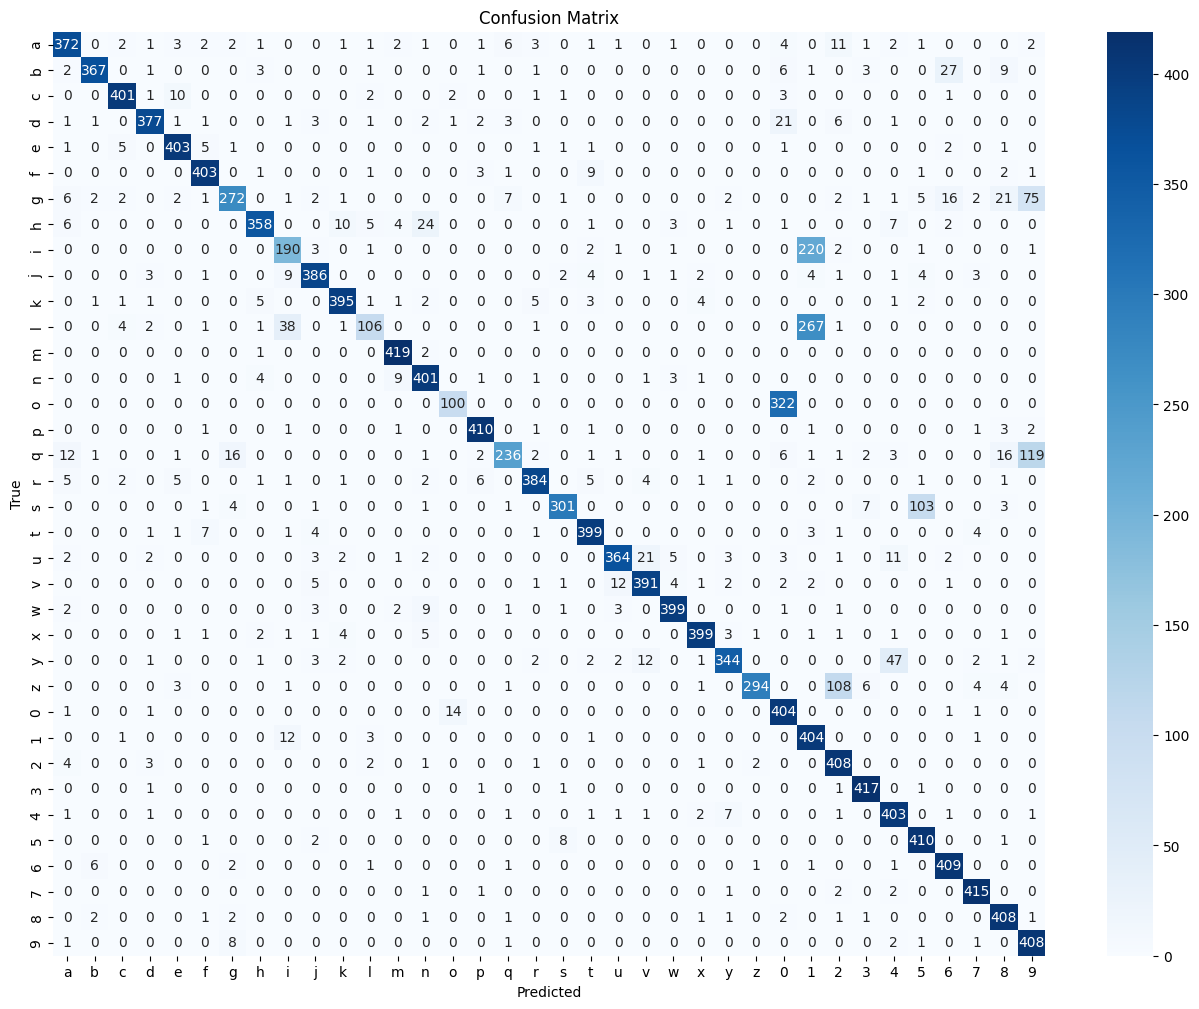

              precision    recall  f1-score   support

           a       0.89      0.88      0.89       422
           b       0.97      0.87      0.92       422
           c       0.96      0.95      0.95       422
           d       0.95      0.89      0.92       422
           e       0.94      0.95      0.94       422
           f       0.95      0.95      0.95       422
           g       0.89      0.64      0.75       422
           h       0.95      0.85      0.90       422
           i       0.74      0.45      0.56       422
           j       0.93      0.91      0.92       422
           k       0.95      0.94      0.94       422
           l       0.85      0.25      0.39       422
           m       0.95      0.99      0.97       422
           n       0.88      0.95      0.91       422
           o       0.85      0.24      0.37       422
           p       0.96      0.97      0.96       422
           q       0.91      0.56      0.69       422
           r       0.95    

In [38]:
def evaluate_model(net, test_loader, classes):
    net.eval()
    all_preds = []
    all_labels = []

    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_hat_test = net(x_test)
        preds = torch.argmax(y_hat_test, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())        
    
    conf_matrix_and_report(all_labels, all_preds, classes)
    # return all_labels, all_preds

# actual_labels, predictions = evaluate_model(net_cd, balanced_test_char_digit_loader, combined_classes)
evaluate_model(net_cd, balanced_test_char_digit_loader, combined_classes)